## Task 4.3 Supervised Learning - Regression and hyperparameter tuning

In [1]:
import pandas as pd

# Define the file path
file_path = '../../data/raw/BloodBrain.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display basic information
print("Dataset Info:")
print(df.info())

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Columns: 135 entries, tpsa to logBBB
dtypes: float64(119), int64(16)
memory usage: 219.5 KB
None

First 5 rows of the dataset:
        tpsa  nbasic  negative    vsa_hyd  a_aro   weight  peoe_vsa.0  \
0  12.030000       1         0  167.06700      0  156.293    76.94749   
1  49.330002       0         0   92.64243      6  151.165    38.24339   
2  50.529999       1         0  295.16700     15  366.485    58.05473   
3  37.389999       0         0  319.11220     15  382.552    62.23933   
4  37.389999       1         0  299.65800     12  326.464    74.80064   

   peoe_vsa.1  peoe_vsa.2  peoe_vsa.3  ...  ctdh  ctaa    mchg    achg  \
0    43.44619     0.00000    0.000000  ...     1     1  0.9241  0.9241   
1    25.52006     0.00000    8.619013  ...     2     2  1.2685  1.0420   
2   124.74020    21.65084    8.619013  ...     1     4  1.2562  1.2562   
3   124.74020    13.19232   21.785640  ...     1    

## Split the dataset

In [2]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns='logBBB')  # all descriptors
y = df['logBBB']               # target variable

# Split into training and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Display the shapes of the resulting datasets
print("Training feature set shape:", X_train.shape)
print("Test feature set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Training feature set shape: (156, 134)
Test feature set shape: (52, 134)
Training labels shape: (156,)
Test labels shape: (52,)


## Select a learning method

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Random Forest Regressor Performance:
Mean Squared Error: 0.2539
R^2 Score: 0.3926


## Perform 10-fold cross-validation

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define a clean parameter grid (no 'auto')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Create the model
rf = RandomForestRegressor(random_state=42)

# GridSearch with 10-fold CV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,                # <- 10-fold cross-validation
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    error_score='raise'   # Optional: reveals detailed error messages
)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

# Display results
print("Best Parameters:", grid_search.best_params_)
print("Best 10-Fold CV R²:", grid_search.best_score_)


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best 10-Fold CV R²: 0.5798849878226449


## Analyze performance values

Model Performance on Test Set:
R² Score: 0.3922
Mean Squared Error: 0.2541

 Top 10 Important Features:
1. fnsa3: 0.0435
2. tpsa: 0.0380
3. prx: 0.0350
4. tcnp: 0.0296
5. most_positive_charge: 0.0282
6. polar_area: 0.0277
7. rpcg: 0.0259
8. tpsa.1: 0.0219
9. psa_npsa: 0.0209
10. pnsa3: 0.0204


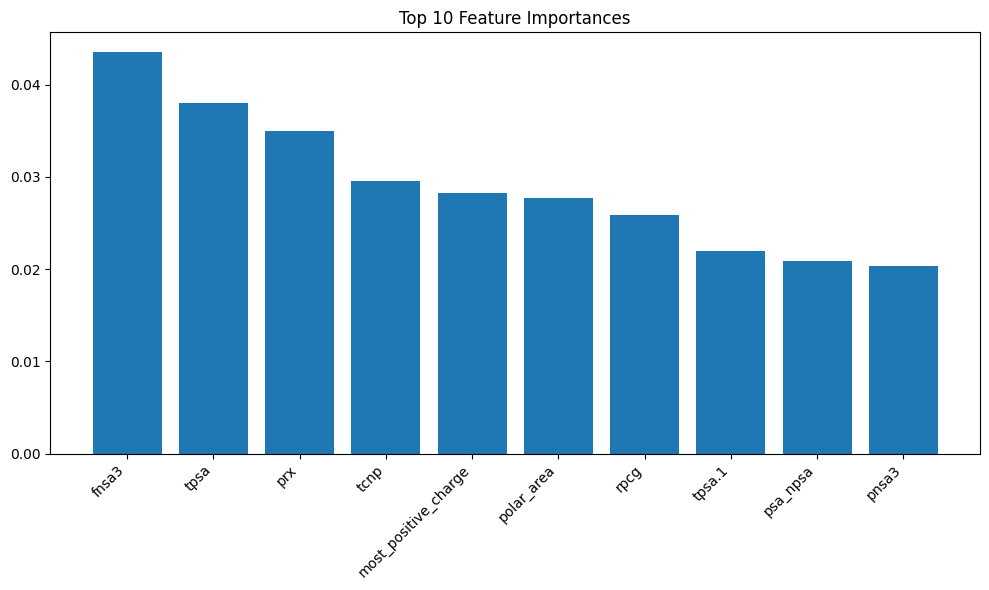

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Use the best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]  # Sort by importance descending

# Display top 10 most important features
print("\n Top 10 Important Features:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Apply the final model to the test set

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Get the best trained model from GridSearchCV
final_model = grid_search.best_estimator_

# Predict on the test data
y_test_pred = final_model.predict(X_test)

# Evaluate predictions
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Final Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Final Model Performance on Test Set:
Mean Squared Error (MSE): 0.2541
R² Score: 0.3922
